In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
from torchvision import datasets, models, transforms
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import time
from PIL import Image

In [2]:
test = pd.read_csv('test_large_4.0.csv')

In [3]:
train= pd.read_csv('train_large_4.0.csv')

In [4]:
train

,path,font,char,code,label
0,char\瑞字\瑞字 楷书 柳公权.jpg,0,瑞,1087,0 1087
1,char\越字\越字 隶书 钱松.jpg,1,越,1659,1 1659
2,char\胡字\胡字 草书 沈学植.jpg,3,胡,1366,3 1366
3,char\攸字\攸字 行书 饶介.jpg,2,攸,725,2 725
4,char\概字\概字 草书 毛泽东.jpg,3,概,855,3 855
...,...,...,...,...,...
51456,char\锥字\锥字 楷书 柳公权.jpg,0,锥,1817,0 1817
51457,char\敝字\敝字 篆书 说文解字.jpg,4,敝,732,4 732
51458,char\区字\区字 篆书 吴昌硕.jpg,4,区,220,4 220
51459,char\吟字\吟字 楷书 王知敬.jpg,0,吟,272,0 272


In [5]:
char_to_code = dict((v,k) for k,v in char_dict.items())

In [25]:
class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel, self).__init__()
        self.eps = 1
        self.k=torch.FloatTensor([10])
        self.model_resnet = models.resnet50(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(4096, num_classes2)
        self.softmax = nn.Softmax(dim=1)
        self.embed =nn.Embedding(5, 2048)

    def font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            result=self.embed(x)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def predict_font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            num=torch.topk(x,1)[1]
            result=self.embed(num)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def forward(self, x,y):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        p = torch.rand(1).item()
        font = self.font_code(y)
        #if p < self.k / (self.k + torch.exp(self.eps / self.k)):
        #    font = self.font_code(y)
        #else:
        #    font = self.predict_font_code(out1)
        #font = self.predict_font_code(out1)
        self.eps +=1
        combined = torch.cat((x.view(x.size(0), -1),font.view(font.size(0), -1)), dim=1)
        out2 = self.fc2(combined)
        return out1, out2

In [5]:
class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel, self).__init__()
        self.eps = 1
        self.k=torch.FloatTensor([10])
        self.model_resnet = models.resnet50(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(4096, num_classes2)
        self.softmax = nn.Softmax(dim=1)
        self.embed =nn.Embedding(5, 2048)

    def font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            result=self.embed(x)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def predict_font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            num=torch.topk(x,1)[1]
            result=self.embed(num)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def forward(self, x,y):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        p = torch.rand(1).item()
        #font = self.font_code(y)
        #if p < self.k / (self.k + torch.exp(self.eps / self.k)):
        #    font = self.font_code(y)
        #else:
        #    font = self.predict_font_code(out1)
        font = self.predict_font_code(out1)
        self.eps +=1
        combined = torch.cat((x.view(x.size(0), -1),font.view(font.size(0), -1)), dim=1)
        out2 = self.fc2(combined)
        return out1, out2

In [26]:
model = MyModel(5,1999)

In [27]:
def training(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    model.train()
    
    for x, y1,y2 in iterator:
        
        x = x.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        
        optimizer.zero_grad()
                
        outputs = model(x,y1)
        
        loss1 = criterion(outputs[0], y1)
        loss2 = criterion(outputs[1], y2)
        loss = loss1 + loss2 
        
        acc1 = calculate_accuracy(outputs[0], y1)
        acc2 = calculate_accuracy(outputs[1], y2)
        #gender_corrects += torch.sum(torch.topk(outputs[0], 1)[1] == torch.topk(y1, 1)[1])
        
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        epoch_acc1 += acc1.item()
        epoch_acc2 += acc2.item()
        
    return epoch_loss / len(iterator),epoch_loss1 / len(iterator),epoch_loss2 / len(iterator), epoch_acc1 / len(iterator),epoch_acc2 / len(iterator)

In [28]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    model.eval()
    
    with torch.no_grad():
    
        for x, y1,y2 in iterator:
        
            x = x.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            loss1 = criterion(outputs[0], y1)
            loss2 = criterion(outputs[1], y2)
            loss = loss1 + loss2 
        
            acc1 = calculate_accuracy(outputs[0], y1)
            acc2 = calculate_accuracy(outputs[1], y2)
            #acc2 = calculate_10_accuracy(outputs[1], y2)

            epoch_loss += loss.item()
            epoch_loss1 += loss1.item()
            epoch_loss2 += loss2.item()
            epoch_acc1 += acc1.item()
            epoch_acc2 += acc2.item()
        
    return epoch_loss / len(iterator),epoch_loss1 / len(iterator),epoch_loss2 / len(iterator), epoch_acc1 / len(iterator),epoch_acc2 / len(iterator)

In [29]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

In [30]:
class MultiTaskDataset():
    def __init__(self,df):
        self.paths = list(df.path)
        self.labels = list(df.label)

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = Image.open(self.paths[idx]).convert('RGB')
        img = preprocess(img)


        #dealing with the labels
        labels = self.labels[idx].split(" ")
        font = torch.tensor(int(labels[0]), dtype=torch.int64)
        code = torch.tensor(int(labels[1]), dtype=torch.int64)
        
        return img.data, font, code

    def show(self,idx):
        x,y = self.__getitem__(idx)
        font,code = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {}".format(font.item(), code.item()))

In [31]:
train_ds = MultiTaskDataset(train)

tr_dataloader=torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)

In [32]:
test_ds = MultiTaskDataset(test)

test_dataloader=torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=0)

In [33]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [34]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [35]:
def calculate_10_accuracy(y_pred, y):
    top_pred = torch.topk(y_pred,10)[1]
    y_resize = y.view(-1,1)
    correct = torch.eq(top_pred, y_resize).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
for i in range(10):
    since=time.time()
    tr_loss,font_loss,char_loss,font_acc,char_acc=training(model, tr_dataloader, optimizer, criterion, device)
    ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc=evaluate(model, test_dataloader, criterion, device)
    mins,secs=epoch_time(since,time.time())
    print('epochs:'+ str(i+1))
    print('min:'+str(mins)+' '+'sec:'+str(secs))
    print('training_loss:'+str(round(tr_loss, 5))+' font_loss:'+str(round(font_loss, 5))+' char_loss:'+str(round(char_loss, 5))+' font_accuracy:'+str(round(font_acc, 5))+' char_accuracy:'+str(round(char_acc, 5)))
    print('test_loss:'+str(round(ts_loss, 5))+' font_loss:'+str(round(ts_font_loss, 5))+' char_loss:'+str(round(ts_char_loss, 5))+' font_accuracy:'+str(round(ts_font_acc, 5))+' char_accuracy:'+str(round(ts_char_acc, 5)))

epochs:1
min:18 sec:59
training_loss:9.75515 font_loss:0.66204 char_loss:9.09311 font_accuracy:0.7165 char_accuracy:0.00217
test_loss:8.48546 font_loss:0.56139 char_loss:7.92407 font_accuracy:0.76307 char_accuracy:0.00708
epochs:2
min:11 sec:11
training_loss:6.40522 font_loss:0.40872 char_loss:5.99649 font_accuracy:0.83545 char_accuracy:0.06211
test_loss:4.70668 font_loss:0.59232 char_loss:4.11436 font_accuracy:0.76565 char_accuracy:0.19089
epochs:3
min:11 sec:23
training_loss:3.22834 font_loss:0.35771 char_loss:2.87064 font_accuracy:0.85465 char_accuracy:0.37954
test_loss:2.25787 font_loss:0.35916 char_loss:1.8987 font_accuracy:0.8524 char_accuracy:0.558
epochs:4
min:14 sec:18
training_loss:1.69751 font_loss:0.30781 char_loss:1.38971 font_accuracy:0.87608 char_accuracy:0.66129
test_loss:1.53412 font_loss:0.32701 char_loss:1.20711 font_accuracy:0.86918 char_accuracy:0.70992
epochs:5
min:15 sec:3
training_loss:1.08542 font_loss:0.26997 char_loss:0.81545 font_accuracy:0.89121 char_accura

In [31]:
ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc=evaluate(model, test_dataloader, criterion, device)
print('test_loss:'+str(round(ts_loss, 5))+' font_loss:'+str(round(ts_font_loss, 5))+' char_loss:'+str(round(ts_char_loss, 5))+' font_accuracy:'+str(round(ts_font_acc, 5))+' char_accuracy:'+str(round(ts_char_acc, 5)))

test_loss:1.82906 font_loss:0.26717 char_loss:1.56188 font_accuracy:0.90198 char_accuracy:0.60565


In [20]:
tr_loss,font_loss,char_loss,font_acc,char_acc=training(model, tr_dataloader, optimizer, criterion, device)

In [21]:
 print('training_loss:'+str(round(tr_loss, 5))+' font_loss:'+str(round(font_loss, 5))+' char_loss:'+str(round(char_loss, 5))+' font_accuracy:'+str(round(font_acc, 5))+' char_accuracy:'+str(round(char_acc, 5)))

training_loss:10.06634 font_loss:0.66258 char_loss:9.40376 font_accuracy:0.72178 char_accuracy:0.00151


In [22]:
#torch.save(model.state_dict(), "D:/caligraphy/test_model3_more_correct.pth")

In [41]:
model.load_state_dict(torch.load("D:/caligraphy/test_model3_more_correct.pth"))

<All keys matched successfully>

In [42]:
ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc=evaluate(model, test_dataloader, criterion, device)

In [43]:
ts_font_acc

0.8874362244897959

In [44]:
ts_char_acc

0.8188010203595064

In [25]:
a,b=evaluate_confusion(model, tr_dataloader, criterion, device)

In [26]:
pred=[]
true=[]
for i in a:
    pred.append(i.numpy()[0])
for i in b:
    true.append(i.item())

In [40]:
pred

[4,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 0,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 4,
 2,
 1,
 3,
 1,
 4,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 0,
 4,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 3,
 2,
 1,
 1,
 4,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 3,
 2,
 2,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 3,
 0,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 4,
 1,
 1,
 2,
 4,
 4,
 1,
 3,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 3,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 2,
 2,
 1,
 2,
 4,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 4,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,


In [27]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

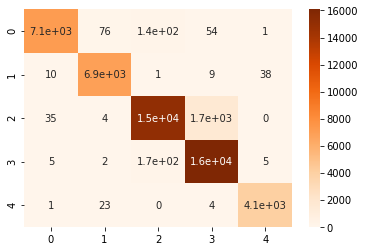

In [28]:
columns = [0,1,2,3,4]

confm = confusion_matrix(true, pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [29]:
confm

array([[ 7124,    76,   137,    54,     1],
       [   10,  6868,     1,     9,    38],
       [   35,     4, 15084,  1656,     0],
       [    5,     2,   174, 16084,     5],
       [    1,    23,     0,     4,  4066]], dtype=int64)

In [24]:
def evaluate_confusion(model, iterator, criterion, device):
    
    pred_result=[]
    y_result=[]
    model.eval()
    
    with torch.no_grad():
    
        for x, y1,y2 in iterator:
            for i in y1:
                y_result.append(i)
            x = x.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            top_pred = outputs[0].argmax(1, keepdim = True).to('cpu')
            for i in top_pred:
                pred_result.append(i)
        
    return pred_result, y_result